In [7]:
#Import Libraries
import os
import csv
# https://github.com/IShengFang/SpectralNormalizationKeras
%run SpectralNormalizationKeras

# Image related Libraries
from PIL import Image
import matplotlib.pyplot as plt
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapOnImage

# Keras Libraries
from keras.layers import Activation, BatchNormalization, Input, LeakyReLU, AveragePooling2D, Add, Concatenate, Flatten, Dense, Lambda, Reshape, Layer
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras import backend as K
from keras.utils import to_categorical
from keras.utils.generic_utils import get_custom_objects

#Tensorflow
import tensorflow as tf

# Numpy
import numpy as np

In [8]:
# Updating Custom Objects to load the model containing spectral normalized layers
get_custom_objects().update({'ConvSN2D': ConvSN2D})
get_custom_objects().update({'ConvSN2DTranspose': ConvSN2DTranspose})

In [9]:
# The self attention layer
class SelfAttention(Layer):
    def __init__(self, output_dim, dimension, **kwargs):
        self.dimension = dimension
        self.output_dim = output_dim
        super(SelfAttention, self).__init__(**kwargs)
   
    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.gamma = self.add_weight(name='gamma', 
                                     shape=(1,),
                                     initializer='zeros',
                                     trainable=True)
        self.f_ = ConvSN2D(self.output_dim//4, 1, strides=1, padding='same', name='selfAttentionFLayer')
        self.g_ = ConvSN2D(self.output_dim//4, 1, strides=1, padding='same', name='selfAttentionGLayer')
        self.h_ = ConvSN2D(self.output_dim//2, 1, strides=1, padding='same', name='selfAttentionHLayer')
        self.v_ = ConvSN2D(self.output_dim, 1, strides=1, padding='same', name='selfAttentionVLayer')
        super(SelfAttention, self).build(input_shape)

    def call(self, x):
        h = w = self.dimension
        N=h*w
        # f layer
        functionF = self.f_(x)
        functionF = K.reshape(functionF, (-1, N, self.output_dim//4))
        # g layer
        functionG = self.g_(x)
        functionG = K.reshape(functionG, (-1, N, self.output_dim//4))
        # creating attention map
        self.attentionMap = tf.matmul(functionF,functionG, transpose_b=True)
        self.attentionMap = Activation('softmax', name='attnMap')(self.attentionMap)
        # h layer
        functionH = self.h_(x)
        functionH = K.reshape(functionH, (-1, N, self.output_dim//2))
        # self attention map
        selfAttention = tf.matmul(self.attentionMap, functionH)
        selfAttention = K.reshape(selfAttention, (-1, h, w, self.output_dim//2))
        # v layer
        functionV = self.v_(selfAttention)
        return x + self.gamma*functionV

    def compute_output_shape(self, input_shape):
        return input_shape
  
    def get_config(self):
        config = {
          'output_dim': self.output_dim,
          'dimension': self.dimension,
        }
        base_config = super(SelfAttention, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [10]:
# Helper methods for creating Discriminator and Generator Layers
def createDiscriminatorBlock(numberOfFilters, input, name, downsample=True):
    residueLayer = input
    inputChannels = input.get_shape().as_list()[-1]
    firstLayer = ConvSN2D(numberOfFilters,3, strides=1,padding='same')(input)
    firstLayer = LeakyReLU(alpha=0.2)(firstLayer)
    secondLayer = ConvSN2D(numberOfFilters,3, strides=1,padding='same')(firstLayer)
    thirdLayer = LeakyReLU(alpha=0.2)(secondLayer)
    fourthLayer = ConvSN2D(numberOfFilters,3, strides=1,padding='same')(thirdLayer)

    if downsample:
        fourthLayer = AveragePooling2D(name = 'averagePoolingLayer1'+name)(fourthLayer)

    if downsample or numberOfFilters != inputChannels:
        residueLayer = ConvSN2D(numberOfFilters,3, strides=1,padding='same')(residueLayer)
    if downsample:
        residueLayer = AveragePooling2D(name = 'averagePoolingLayerResidue1'+name)(residueLayer)
    return Add()([residueLayer, fourthLayer])

def createFirstDiscriminatorBlock(numberOfFilters, input, name, downsample=True):
    residueLayer = input
    firstLayer = ConvSN2D(numberOfFilters,3, strides=1,padding='same')(input)
    secondLayer = LeakyReLU(alpha=0.2)(firstLayer)
    thirdLayer = ConvSN2D(numberOfFilters,3, strides=1,padding='same')(secondLayer)
    thirdLayer = AveragePooling2D(name = 'averagePoolingLayer1'+name)(thirdLayer)
    residueLayer = AveragePooling2D(name = 'averagePoolingLayerResidue1'+name)(residueLayer)
    residueLayer = ConvSN2D(numberOfFilters,3, strides=1,padding='same')(residueLayer)
    return Add()([thirdLayer, residueLayer])

def createGeneratorBlock(numberOfFilters, input, is_training=True):
    residueLayer = input
    firstLayer = BatchNormalization()(input)
    firstLayer = Activation('relu')(firstLayer)
    secondLayer = ConvSN2DTranspose(numberOfFilters, 3, strides=2,padding='same')(firstLayer)

    secondLayer = BatchNormalization()(secondLayer)
    secondLayer = Activation('relu')(secondLayer)
    thirdLayer = ConvSN2DTranspose(numberOfFilters, 3, strides=2,padding='same')(firstLayer)

    residueLayer = ConvSN2DTranspose(numberOfFilters, 3, strides=2,padding='same')(residueLayer)
    return Add()([residueLayer, thirdLayer])

In [11]:
# Discriminator and Generator Methods
def discriminator():
    segmentedImage = Input((256, 256, 1))
    firstLayer = createFirstDiscriminatorBlock(32, segmentedImage, 'discriminatorLayer1') # 128x128
    secondLayer = createDiscriminatorBlock(64, firstLayer, 'discriminatorLayer2') # 64x64
    # self attention layer
    selfAttentionLayerDown = SelfAttention(64, 64, name='selfAttentionLayerDown')(secondLayer)
    thirdLayer = createDiscriminatorBlock(128, selfAttentionLayerDown, 'discriminatorLayer3') # 32x32
    fourthLayer = createDiscriminatorBlock(256, thirdLayer, 'discriminatorLayer4') # 16x16
    fifthLayer = createDiscriminatorBlock(256, fourthLayer, 'discriminatorLayer5') # 8x8
    sixthLayer = createDiscriminatorBlock(512, fifthLayer, 'discriminatorLayer6') # 4x4
    seventhLayer = createDiscriminatorBlock(512, sixthLayer, 'discriminatorLayer7', False) # 4x4
    seventhLayer = LeakyReLU(alpha=0.2)(seventhLayer)

    outputLayer = Flatten()(seventhLayer)
    outputLayer = Dense(1, activation='sigmoid', name='discriminatorDenseLayer8')(outputLayer)
    return Model(input = segmentedImage, output=outputLayer)

def generator(numOfClasses):
    colorImage = Input((256,256,3))
    # downsample
    firstLayer = createFirstDiscriminatorBlock(32, colorImage, 'generatorLayer1') # 128x128
    secondLayer = createDiscriminatorBlock(64, firstLayer, 'generatorLayer2') # 64x64
    # self attention layer
    selfAttentionLayerDown = SelfAttention(64, 64, name='selfAttentionLayerDown')(secondLayer)
    thirdLayer = createDiscriminatorBlock(128, selfAttentionLayerDown, 'generatorLayer3') # 32x32
    fourthLayer = createDiscriminatorBlock(256, thirdLayer, 'generatorLayer4') # 16x16
    fifthLayer = createDiscriminatorBlock(256, fourthLayer, 'generatorLayer5') # 8x8
    sixthLayer = createDiscriminatorBlock(512, fifthLayer, 'generatorLayer6') # 4x4
    seventhLayer = createDiscriminatorBlock(512, sixthLayer, 'generatorLayer7', False) # 4x4
    seventhLayer = LeakyReLU(alpha=0.2)(seventhLayer)

    # upsample
    eighthLayer = createGeneratorBlock(256, seventhLayer) # 8x8
    eighthLayer = Concatenate(name='layer8_concat')([eighthLayer, fifthLayer])

    ninthLayer = createGeneratorBlock(256, eighthLayer) # 16x16
    ninthLayer = Concatenate(name='layer9_concat')([ninthLayer, fourthLayer])

    tenthLayer = createGeneratorBlock(128, ninthLayer) # 32x32
    tenthLayer = Concatenate(name='layer10_concat')([tenthLayer, thirdLayer])

    eleventhLayer = createGeneratorBlock(64, tenthLayer) # 64x64
    eleventhLayer = Concatenate(name='layer11_concat')([eleventhLayer, secondLayer])
    # self attention layer
    selfAttentionLayerUp = SelfAttention(128, 64, name='selfAttentionLayerUp')(eleventhLayer)

    twelfthLayer = createGeneratorBlock(32, selfAttentionLayerUp) # 128x128
    twelfthLayer = Concatenate(name='layer12_concat')([twelfthLayer, firstLayer])
    thirteenthLayer = createGeneratorBlock(32, twelfthLayer) # 256x256

    output = ConvSN2D(numOfClasses,3,padding='same', activation='softmax')(thirteenthLayer)
    return Model(colorImage, output)

In [12]:
# Creating generator and discriminator objects
numOfClasses = 4
generatorSAGAN = generator(numOfClasses)
discriminatorSAGAN = discriminator()








D:\Anaconda\envs\KerasGPU\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("di...)`


In [13]:
# Compiling the discriminator
generatorSAGAN.summary()
discriminatorSAGAN.summary()
discriminatorSAGAN.compile(loss='binary_crossentropy', optimizer=Adam(6e-6, beta_1=0.5), metrics=['accuracy'])


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv_s_n2d_1 (ConvSN2D)         (None, 256, 256, 32) 928         input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 256, 256, 32) 0           conv_s_n2d_1[0][0]               
__________________________________________________________________________________________________
conv_s_n2d_2 (ConvSN2D)         (None, 256, 256, 32) 9280        leaky_re_lu_1[0][0]              
__________________________________________________________________________________________________
averagePoo

In [14]:
# SAGAN model method
def createSAGan(generatorSAGAN, discriminatorSAGAN):
    colorImage = Input((256,256,3))
    generatorImage = generatorSAGAN(colorImage)
    generatorImage1 =  Lambda(lambda x: K.argmax(x, axis= 3), trainable=False, name='SAGANargmax')(generatorImage)
    generatorImage1 =  Lambda(lambda x: K.cast(x, dtype='float32'), trainable=False, name='SAGANcast')(generatorImage1)
    generatorImage1 =  Lambda(lambda x: K.expand_dims(x, axis= 3), trainable=False, name='SAGANexpanddims')(generatorImage1)
    discriminatorSAGAN.trainable = False
    discriminatorOutput = discriminatorSAGAN(generatorImage1)
    return Model(colorImage,outputs=[discriminatorOutput, generatorImage])

In [15]:
# loading the models
discriminatorSAGAN = load_model('SAGanDisc_model.h5',custom_objects={'SelfAttention': SelfAttention })
generatorSAGAN = load_model('SAGanGen_model.h5',custom_objects={'SelfAttention': SelfAttention })

D:\Anaconda\envs\KerasGPU\lib\site-packages\keras\engine\saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [16]:
# Creating combined SAGAN object
combined_model = createSAGan(generatorSAGAN, discriminatorSAGAN)
combined_model.summary()
combined_model.compile(loss=['binary_crossentropy','categorical_crossentropy'], optimizer=Adam(2e-4, beta_1=0.5), metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
model_1 (Model)              (None, 256, 256, 4)       25179786  
_________________________________________________________________
SAGANargmax (Lambda)         (None, 256, 256)          0         
_________________________________________________________________
SAGANcast (Lambda)           (None, 256, 256)          0         
_________________________________________________________________
SAGANexpanddims (Lambda)     (None, 256, 256, 1)       0         
_________________________________________________________________
model_2 (Model)              (None, 1)                 18868482  
Total params: 44,048,268
Trainable params: 25,165,350
Non-trainable params: 18,882,918
_______________________________________________________

In [17]:
# Augment Images by using transformations
# https://towardsdatascience.com/data-augmentation-for-deep-learning-4fe21d1a4eb9
# https://imgaug.readthedocs.io/en/latest/
ia.seed(1)

# Sometimes(0.5, ...) applies the given augmenter in 50% of all cases,
# e.g. Sometimes(0.5, GaussianBlur(0.3)) would blur roughly every second
# image.
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

# Define our sequence of augmentation steps that will be applied to every image.
seq = iaa.Sequential(
    [
        #
        # Apply the following augmenters to most images.
        #
        iaa.Fliplr(1), # horizontally flip all images
        iaa.Flipud(1), # vertically flip all images

        # Apply affine transformations to some of the images
        # - scale to 80-120% of image height/width (each axis independently)
        # - translate by -20 to +20 relative to height/width (per axis)
        # - rotate by -45 to +45 degrees
        # - shear by -16 to +16 degrees
        # - order: use nearest neighbour or bilinear interpolation (fast)
        # - mode: use any available mode to fill newly created pixels
        #         see API or scikit-image for which modes are available
        # - cval: if the mode is constant, then use a random brightness
        #         for the newly created pixels (e.g. sometimes black,
        #         sometimes white)
        sometimes(iaa.Affine(
            rotate=(-45, 45),
            # shear=(-16, 16),
            order=[0, 1],
            cval=(0, 255),
            mode=ia.ALL
        )),
    ],
    # do all of the above augmentations in random order
    random_order=True
)

In [18]:
# Methods to fetch images
def getImageNames(filePath):
    imageNames = []
    for fileName in os.listdir(filePath):
        imageNames.append(fileName)
    return imageNames
  
def data_generator(imageNames, batchSize):
    imagePath = "/content/prodocyteData/TRAINING_data/images/"
    annotatedImagePath = "/content/prodocyteData/TRAINING_data/masks/"
    oneFourth = int(batchSize/4)
    while True:
        wsiImages = []
        annotatedImages = []
        imageBatch = np.random.choice(imageNames, 2*batchSize)
        i = 0
        for imageName in imageBatch:
            # print(imageName)
            annotatedImage = np.array(Image.open(annotatedImagePath+imageName[:-3]+'png').resize((256,256))).reshape(256,256,1)
            if {85, 170, 255}.intersection(np.unique(annotatedImage)):
                annotatedImage = np.array(annotatedImage/np.unique(annotatedImage)[1],dtype=np.int32)
            wsiImages.append(np.array(Image.open(imagePath+imageName).resize((256,256)), 'float32')/127.5 -1)
            annotatedImages.append(to_categorical(annotatedImage, num_classes=numOfClasses))
            i += 1
            if i == oneFourth:
                for _ in range(2):
                    segmentationMaps = []
                    for segmentedImage in annotatedImages:
                        # Convert mask to binary map
                        np_mask = np.array(segmentedImage)
                        np_mask = np.clip(np_mask, 0, 1)
                        
                        # Create segmentation map
                        segmap = np.zeros(annotatedImages[0].shape, dtype=bool)
                        segmap[:] = np_mask
                        segmap = SegmentationMapOnImage(segmap, shape=annotatedImages[0].shape)
                        segmentationMaps.append(segmap)
                    images_aug, seg_aug = seq(images=wsiImages,segmentation_maps=segmentationMaps)
                    for segImage in seg_aug:
                        annotatedImages.append(segImage.arr)
                        wsiImages.extend(images_aug)
                break
        yield np.array(wsiImages), np.array(annotatedImages)

In [ ]:
# Get images and view a couple of pairs of original as well as segmented image
imageNames = getImageNames("/content/prodocyteData/TRAINING_data/images/")
np.random.seed(1)
np.random.shuffle(imageNames)
trainImages, testImages =  imageNames[:-100], imageNames[-100:]

_, axs = plt.subplots(2, 4, figsize=(10, 10))
for i, d in enumerate(data_generator(trainImages, 4)):
    axs[i][0].imshow(d[0][0]*0.5+0.5)
    axs[i][1].imshow(np.argmax(d[1], axis = -1)[0], cmap='Greys_r')
    axs[i][2].imshow(d[0][1]*0.5+0.5)
    axs[i][3].imshow(np.argmax(d[1], axis = -1)[1], cmap='Greys_r')
    if(i == 1):
        break

In [ ]:
# Train the model
%%time
# Training SAGAN
batchSize = 8
iteration = 512
epochs = 10
discriminatorLossArray, SAGanGeneratorLoss, discriminatorAccuracy, SAGanGeneratorAccuracy = [], [], [], []

real = np.ones((batchSize, 1))
fake = np.zeros((batchSize, 1))
for epoch in range(epochs):
    for i, d in enumerate(data_generator(trainImages, batchSize)):
        generatedImage = generatorSAGAN.predict(d[0])
        generatedImage = np.argmax(generatedImage, axis=-1).reshape((batchSize,256,256,1))
        segmentedImage =  np.argmax(d[1], axis=-1).reshape((batchSize,256,256,1))
        discriminatorLossReal = discriminatorSAGAN.train_on_batch(segmentedImage, real)
        discriminatorLossFake = discriminatorSAGAN.train_on_batch(generatedImage, fake)
        discriminatorLoss = 0.5* np.add(discriminatorLossReal , discriminatorLossFake)
        discriminatorLossArray.append(discriminatorLoss[0])
        # discriminatorAccuracy.append(100*discriminatorLoss[1])
        
        SAGan_loss = combined_model.train_on_batch(d[0], [real,d[1]])

        SAGanGeneratorLoss.append(SAGan_loss[0])
        # SAGanGeneratorAccuracy.append(100*SAGan_loss[1])
        if(i%10 == 0):
            print("Epoch %d/%d   iteration %d/%d  D Acc %3d%%  D Loss: %f    SAGAN Loss: %f" % 
                  (epoch+1, epochs, i, iteration, 100*discriminatorLoss[1], discriminatorLoss[0], SAGan_loss[0]))
            
        if(i == iteration-1):
            break
    if (epoch+1) % 2 == 0:
        # Writing to results to a file after 2 epochs
        with open('drive/My Drive/IS/discriminatorLossFile.csv', mode='a') as discriminatorLossFile:
            discriminatorLossFile_writer = csv.writer(discriminatorLossFile, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
            discriminatorLossFile_writer.writerow(discriminatorLossArray)
            discriminatorLossArray = []
        with open('drive/My Drive/IS/SAGanLossFile.csv', mode='a') as SAGanLossFile:
            SAGanLossFile_writer = csv.writer(SAGanLossFile, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
            SAGanLossFile_writer.writerow(SAGanGeneratorLoss)
            SAGanGeneratorLoss = []
        rpath = 'drive/My Drive/IS/results/'
        fig, axs = plt.subplots(1, 3, figsize=(15, 15))
        for k, l in enumerate(data_generator(trainImages, 4)):
            generatedImage = generatorSAGAN.predict(l[0])
            axs[0].imshow(l[0][0]*0.5+0.5)
            axs[1].imshow((np.argmax(l[1], axis=-1)[0].reshape((1,256,256,1))*0.5 + 0.5).reshape(256, 256))
            axs[2].imshow((np.argmax(generatedImage[0], axis=-1).reshape((1,256,256,1))*0.5 + 0.5).reshape(256, 256))
            if k == 1:
                break
        fig.savefig(rpath+ '{}_{}_result_{}.png'.format(epoch,i,k))
        plt.close()
        generatorSAGAN.save('drive/My Drive/IS/SAGanGen_model.h5')
        discriminatorSAGAN.save('drive/My Drive/IS/SAGanDisc_model.h5')

In [20]:
# Methods to show graphs
# https://stackoverflow.com/questions/42281844/what-is-the-mathematics-behind-the-smoothing-parameter-in-tensorboards-scalar
def smooth(scalars, weight) :  # Weight between 0 and 1
    if not scalars: return
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value
    return smoothed
  
# https://realpython.com/python-csv/
def plotGraph(filename, smoothingFactor):
    with open(filename) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        graph = []
        for row in csv_reader:
            for column in row:
                graph.append(float(column))
    graph = smooth(graph, smoothingFactor)
    plt.plot(graph)
    return

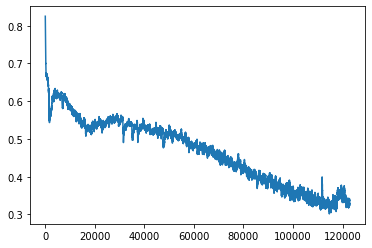

In [21]:
# Discriminator Loss
plotGraph('discriminatorLossFile.csv', 0.995)

In [22]:
# Different Metrics to show results
def conf_matrix(y_true, y_pred, labels):
    conf_mat = np.zeros((labels, labels))
    for b in range(y_true.shape[0]):
        for i in range(y_true.shape[1]):
            for j in range(y_true.shape[2]):
                conf_mat[y_true[b][i][j]][y_pred[b][i][j]] += 1
    return np.array(conf_mat)

def accuracy(cm):
    return np.sum(np.diag(cm))/cm.sum()

def recall(cm, labels):
    r = np.diag(cm)/np.sum(cm, axis = 1)
    return np.mean(r), np.rec.fromarrays([labels.reshape(-1, 1), r.reshape(-1,1)], names=['label', 'value'])

def precision(cm, labels):
    p = np.diag(cm)/np.sum(cm, axis = 0)
    return np.mean(p), np.rec.fromarrays([labels.reshape(-1, 1), p.reshape(-1,1)], names=['label', 'value'])

def mIOU(cm, labels):
    iou = np.diag(cm)/(np.sum(cm, axis=0) + np.sum(cm, axis=1) - np.diag(cm))
    return np.mean(iou), np.rec.fromarrays([labels.reshape(-1, 1), iou.reshape(-1,1)], names=['label', 'value'])

def f1_score(precision, recall):
    return (2*precision*recall)/(precision+recall)

def get_all_metrics(generator, labels):
    annotatedImages = []
    segmentedImages = []
    for image in testImages:
        imagePath = "/content/prodocyteData/TRAINING_data/images/"
        annotatedImagePath = "/content/prodocyteData/TRAINING_data/masks/"
        annotatedImage = np.array(Image.open(annotatedImagePath+image[:-3]+'png').resize((256,256))).reshape(256,256)
        if {85, 170, 255}.intersection(np.unique(annotatedImage)):
            annotatedImage = np.array(annotatedImage/np.unique(annotatedImage)[1],dtype=np.int32)
        annotatedImages.append(annotatedImage)
        generatedImage = generator.predict(np.array(np.array(Image.open(imagePath+image).resize((256,256)), 'float32')/127.5 -1).reshape(1,256,256,3))
        segmentedImage = (np.argmax(generatedImage, axis=-1)[0].reshape((1,256,256,1))).reshape(256, 256)
        segmentedImages.append(segmentedImage)
    dic = {}
    cm = conf_matrix(np.array(annotatedImages), np.array(segmentedImages), len(labels))
    dic['full_accuracy'] = accuracy(cm)*100
    dic['class_accuracy'] = accuracy(cm[1:, 1:])*100
    dic['precision'], dic['per_class_precision'] = precision(cm, labels)
    dic['recall'], dic['per_class_recall'] = recall(cm, labels)
    dic['mIOU'], dic['IOU'] = mIOU(cm, labels)
    dic['f1_score'] = f1_score(dic['precision'], dic['recall'])
    dic['per_class_f1_score'] = f1_score(dic['per_class_precision']['value'], dic['per_class_recall']['value'])
    return dic

In [ ]:
dictResults = get_all_metrics(generatorSAGAN, np.array(['background', 'glomeruli', 'podocyte', 'non-podocyte']))
print(dictResults)

In [ ]:
# result of segmentation on one image
from sklearn.metrics import f1_score
_, axs = plt.subplots(2, 3, figsize=(10, 10))
for i, d in enumerate(data_generator(testImages, 4)):
    axs[i][0].imshow(d[0][0]*0.5+0.5)
    generatedImage = generatorSAGAN.predict(d[0])
    segmentedImage = (np.argmax(generatedImage, axis=-1)[0].reshape((1,256,256,1))).reshape(256, 256)
    axs[i][2].imshow(segmentedImage)
    print('predict', np.unique(segmentedImage,return_counts=True))
    actualImage = np.argmax(d[1][0],axis=-1)
    axs[i][1].imshow(actualImage)
    print('actual ', np.unique(actualImage,return_counts=True))
    print('class 0 - score - ', f1_score(actualImage.ravel(), segmentedImage.ravel(), labels=[0], average='micro'))
    print('class 1 - score - ', f1_score(actualImage.ravel(), segmentedImage.ravel(), labels=[1], average='micro'))
    print('class 2 - score - ', f1_score(actualImage.ravel(), segmentedImage.ravel(), labels=[2], average='micro'))
    print('class 3 - score - ', f1_score(actualImage.ravel(), segmentedImage.ravel(), labels=[3], average='micro'))
    if(i == 1):
        break